In [1]:
import openmc.deplete as dpl
import openmc.data as data
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
results = dpl.results.Results('10kp_50i_100b/depletion_results.h5')

<ErrorbarContainer object of 3 artists>

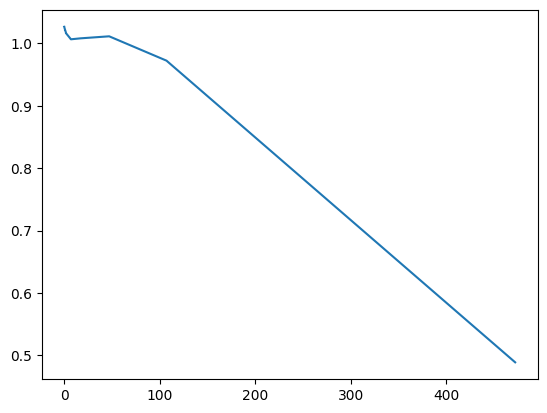

In [3]:
t, k_ = results.get_keff('d')
k_eff, err = list(zip(*k_))
plt.errorbar(t, k_eff, err)

In [4]:
results.get_atoms('1','Pu239')

(array([    0., 21600., 86400.]),
 array([0.00000000e+00, 1.82379730e+21, 3.11614374e+22]))